In [24]:
import boto3
import json 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.json
import psycopg2 as ps 
import seaborn as sns
pd.plotting.register_matplotlib_converters() 
%matplotlib inline

In [2]:
f = open("credentials.json")
credentials = json.load(f)

my_path = list(credentials.values())[0]
weather_key = list(credentials.values())[1]
aws_access_key = list(credentials.values())[2]
aws_secret_key = list(credentials.values())[3]
rds_host = list(credentials.values())[4]
rds_user = list(credentials.values())[5]
rds_password = list(credentials.values())[6]
rds_database = list(credentials.values())[7]
rds_charset = list(credentials.values())[8]
rds_port = list(credentials.values())[9]

In [3]:
# Import weather_history_bulk JSON file
f = open("weather_history_bulk.json")
weather_history_bulk = json.load(f)

In [4]:
# Convert JSON file to DataFrame
dataframe = pd.json_normalize(weather_history_bulk)

In [5]:
# Data exploration
dataframe.head

<bound method NDFrame.head of                  dt                         dt_iso  timezone  \
0         283996800  1979-01-01 00:00:00 +0000 UTC      3600   
1         284000400  1979-01-01 01:00:00 +0000 UTC      3600   
2         284004000  1979-01-01 02:00:00 +0000 UTC      3600   
3         284007600  1979-01-01 03:00:00 +0000 UTC      3600   
4         284011200  1979-01-01 04:00:00 +0000 UTC      3600   
...             ...                            ...       ...   
1972435  1704135600  2024-01-01 19:00:00 +0000 UTC    -28800   
1972436  1704139200  2024-01-01 20:00:00 +0000 UTC    -28800   
1972437  1704142800  2024-01-01 21:00:00 +0000 UTC    -28800   
1972438  1704146400  2024-01-01 22:00:00 +0000 UTC    -28800   
1972439  1704150000  2024-01-01 23:00:00 +0000 UTC    -28800   

                                                   weather  visibility  \
0        [{'id': 801, 'main': 'Clouds', 'description': ...     10000.0   
1        [{'id': 800, 'main': 'Clear', 'description':

In [6]:
dataframe.shape 

(1972440, 23)

In [7]:
dataframe.columns

Index(['dt', 'dt_iso', 'timezone', 'weather', 'visibility', 'lon', 'city_name',
       'lat', 'main.temp', 'main.temp_min', 'main.temp_max', 'main.feels_like',
       'main.pressure', 'main.humidity', 'main.dew_point', 'clouds.all',
       'wind.speed', 'wind.deg', 'snow.1h', 'wind.gust', 'rain.1h', 'rain.3h',
       'snow.3h'],
      dtype='object')

In [8]:
dataframe.tail

<bound method NDFrame.tail of                  dt                         dt_iso  timezone  \
0         283996800  1979-01-01 00:00:00 +0000 UTC      3600   
1         284000400  1979-01-01 01:00:00 +0000 UTC      3600   
2         284004000  1979-01-01 02:00:00 +0000 UTC      3600   
3         284007600  1979-01-01 03:00:00 +0000 UTC      3600   
4         284011200  1979-01-01 04:00:00 +0000 UTC      3600   
...             ...                            ...       ...   
1972435  1704135600  2024-01-01 19:00:00 +0000 UTC    -28800   
1972436  1704139200  2024-01-01 20:00:00 +0000 UTC    -28800   
1972437  1704142800  2024-01-01 21:00:00 +0000 UTC    -28800   
1972438  1704146400  2024-01-01 22:00:00 +0000 UTC    -28800   
1972439  1704150000  2024-01-01 23:00:00 +0000 UTC    -28800   

                                                   weather  visibility  \
0        [{'id': 801, 'main': 'Clouds', 'description': ...     10000.0   
1        [{'id': 800, 'main': 'Clear', 'description':

In [9]:
# Create seperate DataFrames by location
weather_history_berlin = dataframe.loc[dataframe['city_name'] == 'Berlin']
weather_history_tulum = dataframe.loc[dataframe['city_name'] == 'Tulum']
weather_history_corcovado = dataframe.loc[dataframe['city_name'] == 'Parque Nacional Corcovado']
weather_history_kotao = dataframe.loc[dataframe['city_name'] == 'Ko Tao']
weather_history_sandiego = dataframe.loc[dataframe['city_name'] == 'San Diego']

In [10]:
# Convert timestamp to date, add Y and YM column
pd.set_option('mode.chained_assignment', None)

city_dfs = [weather_history_berlin, weather_history_tulum, weather_history_corcovado, weather_history_kotao, weather_history_sandiego]

def to_datetime(dfs, timestamp_column, date_column):
    dfs[date_column] = pd.to_datetime(dfs[timestamp_column], unit='s')
    dfs.drop(columns=[timestamp_column], inplace=True)
    dfs['Y'] = dfs[date_column].dt.year

for dfs in city_dfs:
    to_datetime(dfs, 'dt', 'date_column')

In [11]:
weather_history_sandiego.tail

<bound method NDFrame.tail of                                 dt_iso  timezone  \
1577952  1979-01-01 00:00:00 +0000 UTC    -28800   
1577953  1979-01-01 01:00:00 +0000 UTC    -28800   
1577954  1979-01-01 02:00:00 +0000 UTC    -28800   
1577955  1979-01-01 03:00:00 +0000 UTC    -28800   
1577956  1979-01-01 04:00:00 +0000 UTC    -28800   
...                                ...       ...   
1972435  2024-01-01 19:00:00 +0000 UTC    -28800   
1972436  2024-01-01 20:00:00 +0000 UTC    -28800   
1972437  2024-01-01 21:00:00 +0000 UTC    -28800   
1972438  2024-01-01 22:00:00 +0000 UTC    -28800   
1972439  2024-01-01 23:00:00 +0000 UTC    -28800   

                                                   weather  visibility  \
1577952  [{'id': 721, 'main': 'Haze', 'description': 'h...     10000.0   
1577953  [{'id': 800, 'main': 'Clear', 'description': '...         NaN   
1577954  [{'id': 800, 'main': 'Clear', 'description': '...         NaN   
1577955  [{'id': 721, 'main': 'Haze', 'descriptio

In [12]:
# Filter out data from 2024 for annual mean temperature (few data points)
def filter_out_year(df):
    df.drop(df[df['Y'] == 2024].index, inplace=True)

# Replace NaN by 0
def replace_nan_with_zero(df):
    df.fillna(0, inplace=True)

# Process each dataframe
for i in city_dfs:
    filter_out_year(i)
    replace_nan_with_zero(i)

In [13]:
# Check the last few rows of weather_history_sandiego to verify changes
print(weather_history_sandiego.tail())

                                dt_iso  timezone  \
1972411  2023-12-31 19:00:00 +0000 UTC    -28800   
1972412  2023-12-31 20:00:00 +0000 UTC    -28800   
1972413  2023-12-31 21:00:00 +0000 UTC    -28800   
1972414  2023-12-31 22:00:00 +0000 UTC    -28800   
1972415  2023-12-31 23:00:00 +0000 UTC    -28800   

                                                   weather  visibility  \
1972411  [{'id': 701, 'main': 'Mist', 'description': 'm...      9656.0   
1972412  [{'id': 500, 'main': 'Rain', 'description': 'l...     10000.0   
1972413  [{'id': 500, 'main': 'Rain', 'description': 'l...     10000.0   
1972414  [{'id': 500, 'main': 'Rain', 'description': 'l...     10000.0   
1972415  [{'id': 500, 'main': 'Rain', 'description': 'l...     10000.0   

                lon  city_name        lat  main.temp  main.temp_min  \
1972411 -117.161084  San Diego  32.715738      14.10          13.23   
1972412 -117.161084  San Diego  32.715738      14.77          13.55   
1972413 -117.161084  San Dieg

In [14]:
# Save the filtered weather data for annual mean temperature in separate dataframe
filtered_weather_history_berlin = city_dfs[0]
filtered_weather_history_tulum = city_dfs[1]
filtered_weather_history_corcovado = city_dfs[2]
filtered_weather_history_kotao = city_dfs[3]
filtered_weather_history_sandiego = city_dfs[4]
    
# Transform the filtered dataframes to remove unneccessary data
selected_columns = ['city_name', 'date_column', 'main.temp', 'rain.1h', 'Y']

filtered_weather_history_berlin = filtered_weather_history_berlin[selected_columns]
filtered_weather_history_tulum = filtered_weather_history_tulum[selected_columns]
filtered_weather_history_corcovado = filtered_weather_history_corcovado[selected_columns]
filtered_weather_history_kotao = filtered_weather_history_kotao[selected_columns]
filtered_weather_history_sandiego = filtered_weather_history_sandiego[selected_columns]

In [15]:
# Transform the unfiltered dataframes to remove unneccessary data
selected_columns = ['city_name', 'date_column', 'main.temp', 'rain.1h', 'Y']

weather_history_berlin = weather_history_berlin[selected_columns]
weather_history_tulum = weather_history_tulum[selected_columns]
weather_history_corcovado = weather_history_corcovado[selected_columns]
weather_history_kotao = weather_history_kotao[selected_columns]
weather_history_sandiego = weather_history_sandiego[selected_columns]

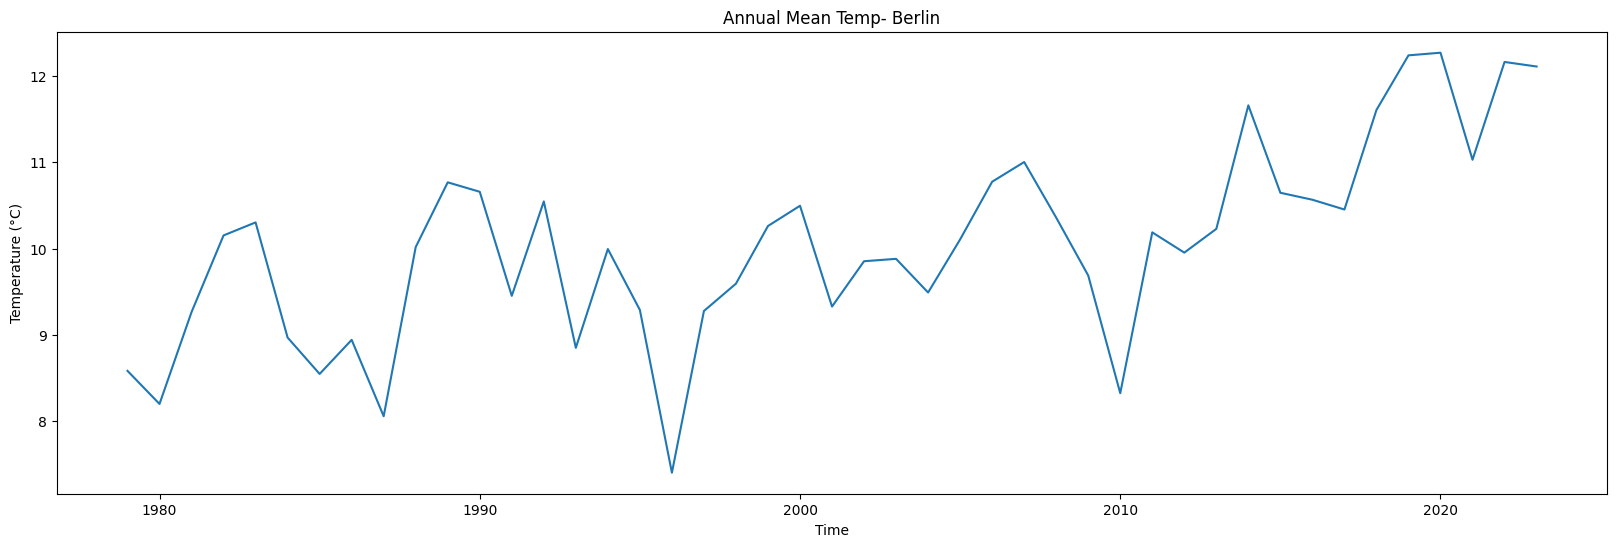

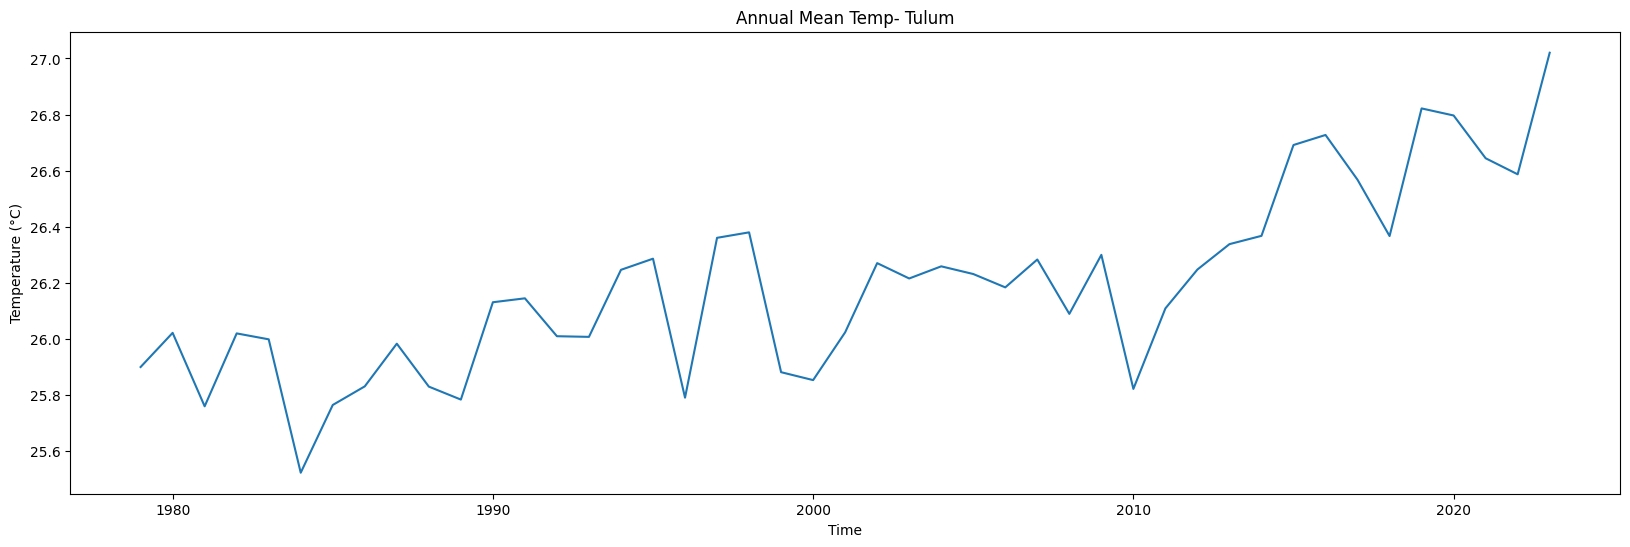

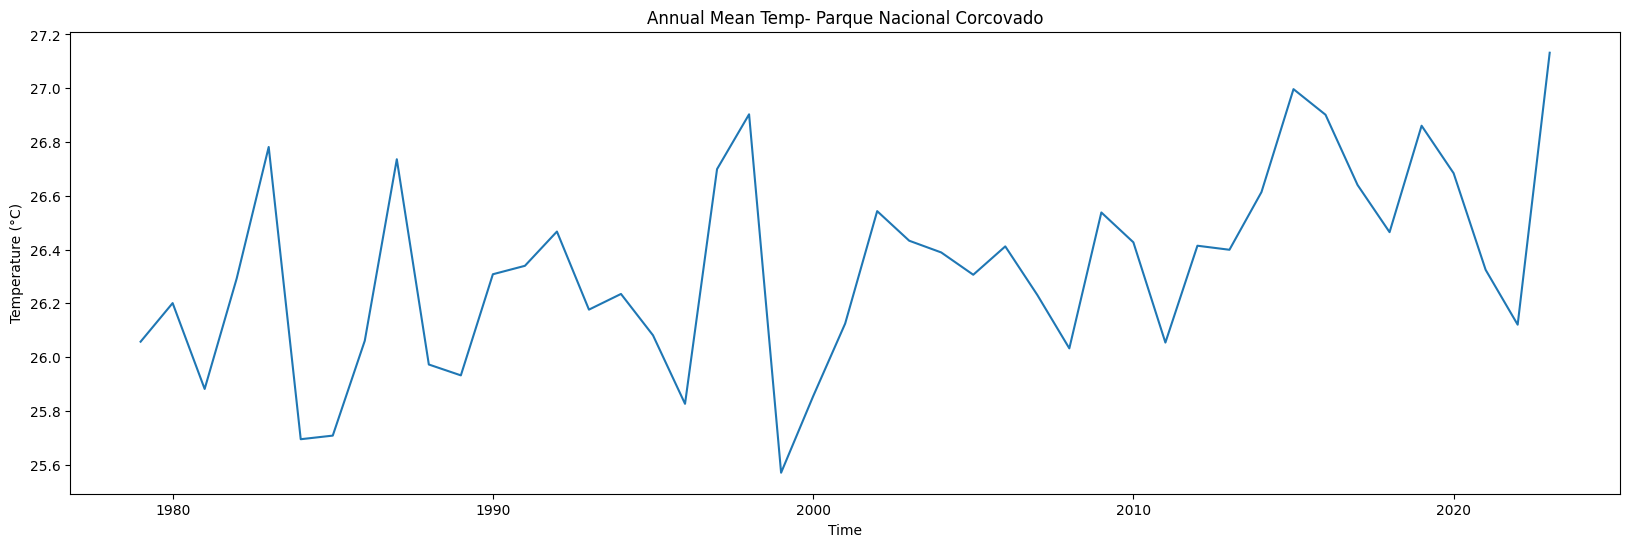

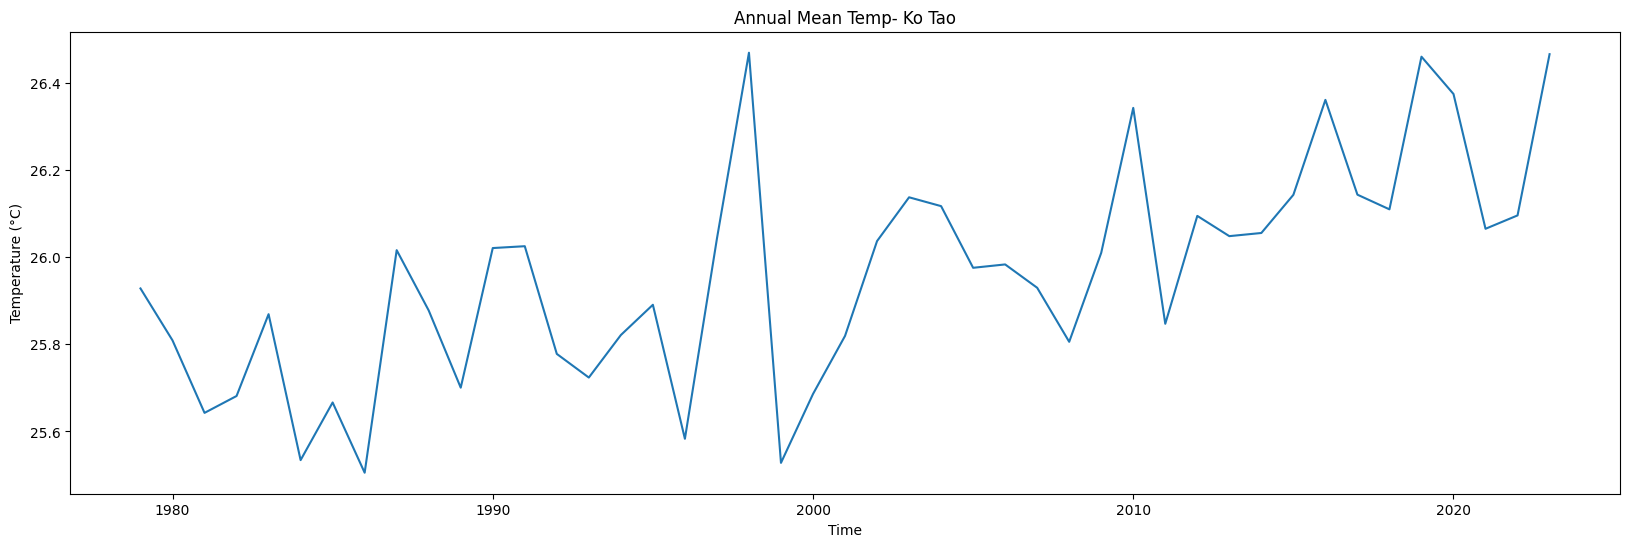

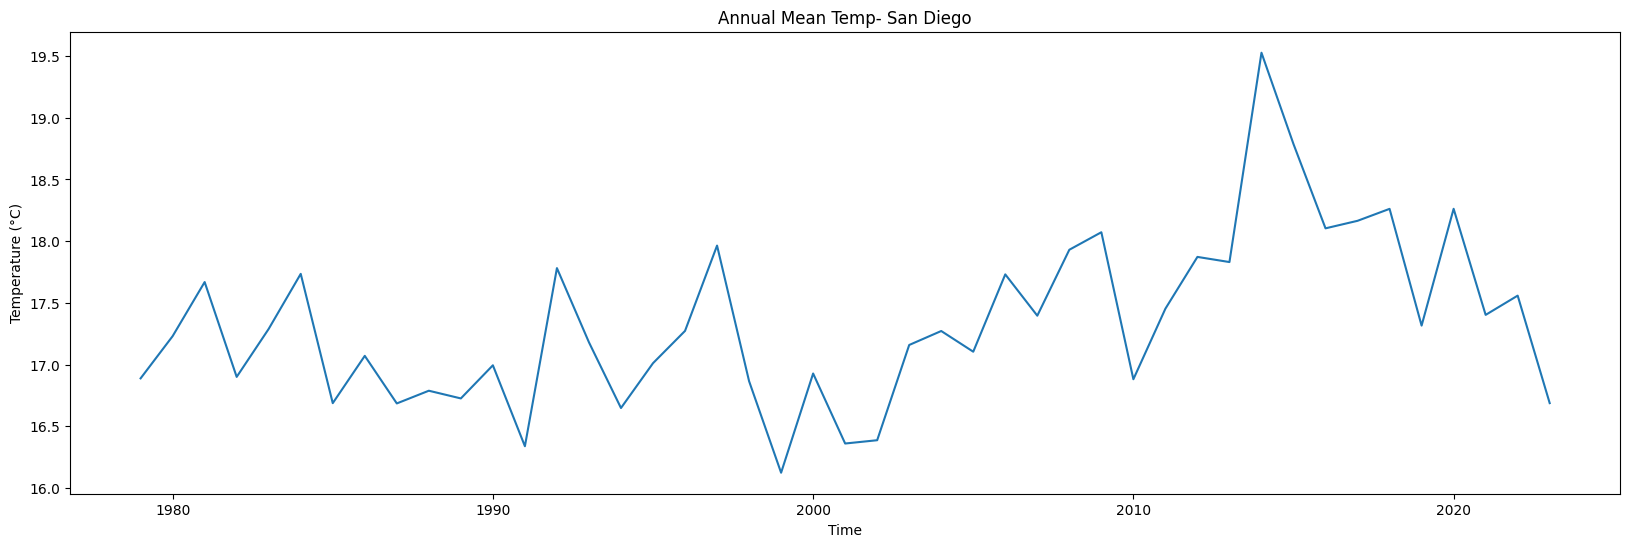

In [16]:
# Plots of annual mean temperatures
filtered_city_dfs = [filtered_weather_history_berlin, filtered_weather_history_tulum, filtered_weather_history_corcovado, filtered_weather_history_kotao, filtered_weather_history_sandiego]

def plot_medium_temp(df, city_name):
    df['main.temp'].groupby(df['Y']).mean().plot(figsize=(20, 6), title=f'Annual Mean Temp- {city_name}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.show()

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    plot_medium_temp(df, city_name)

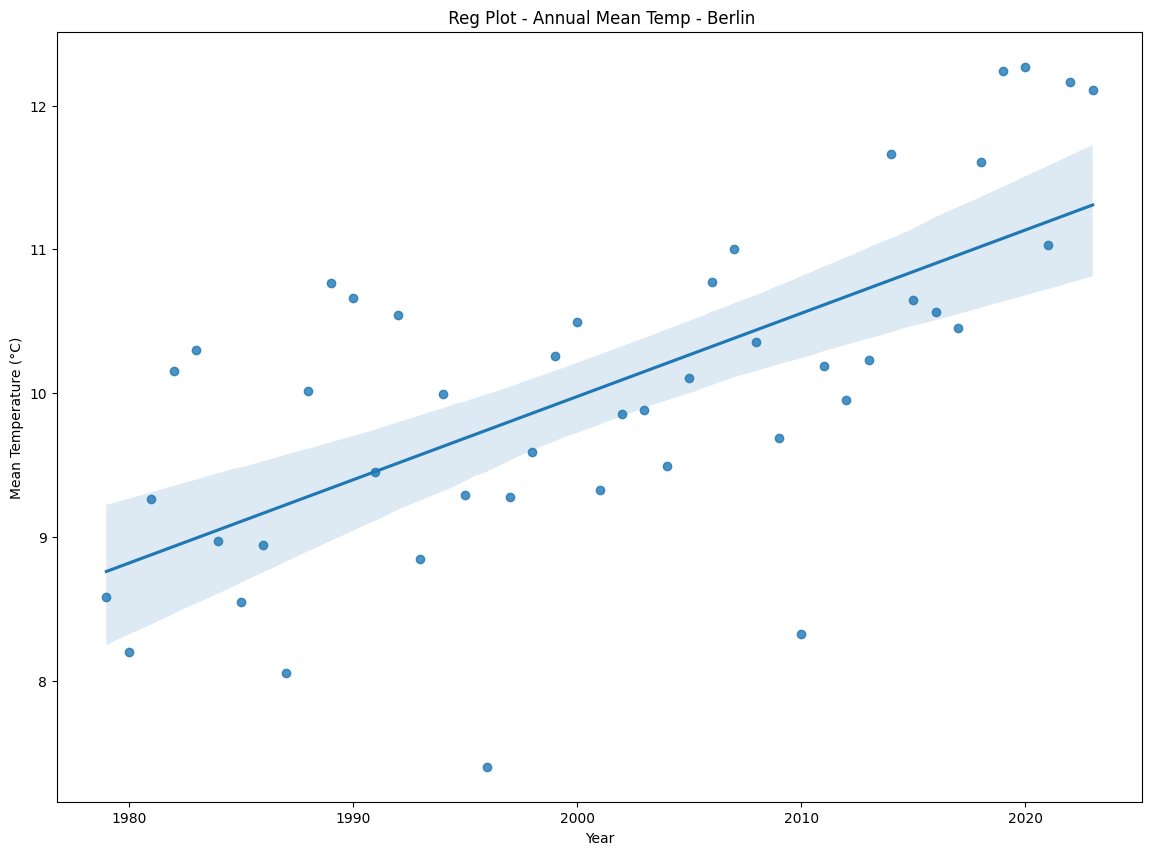

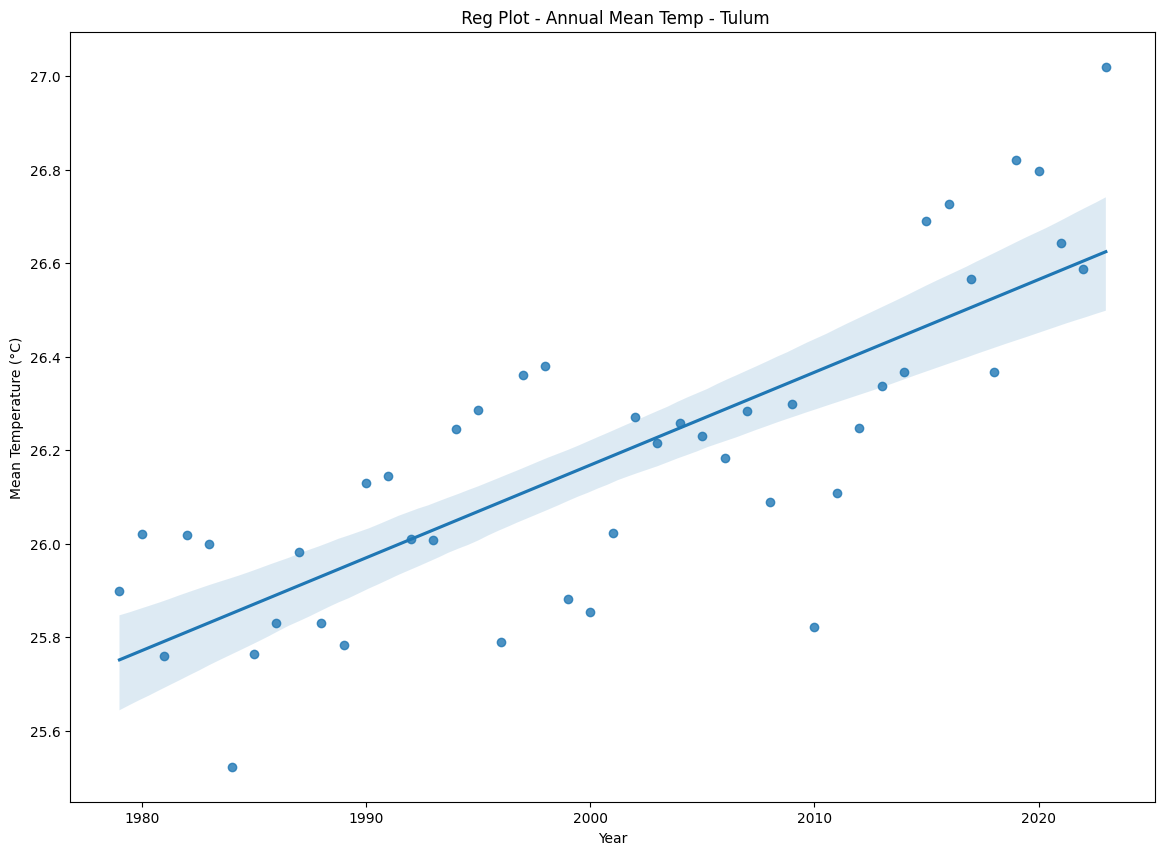

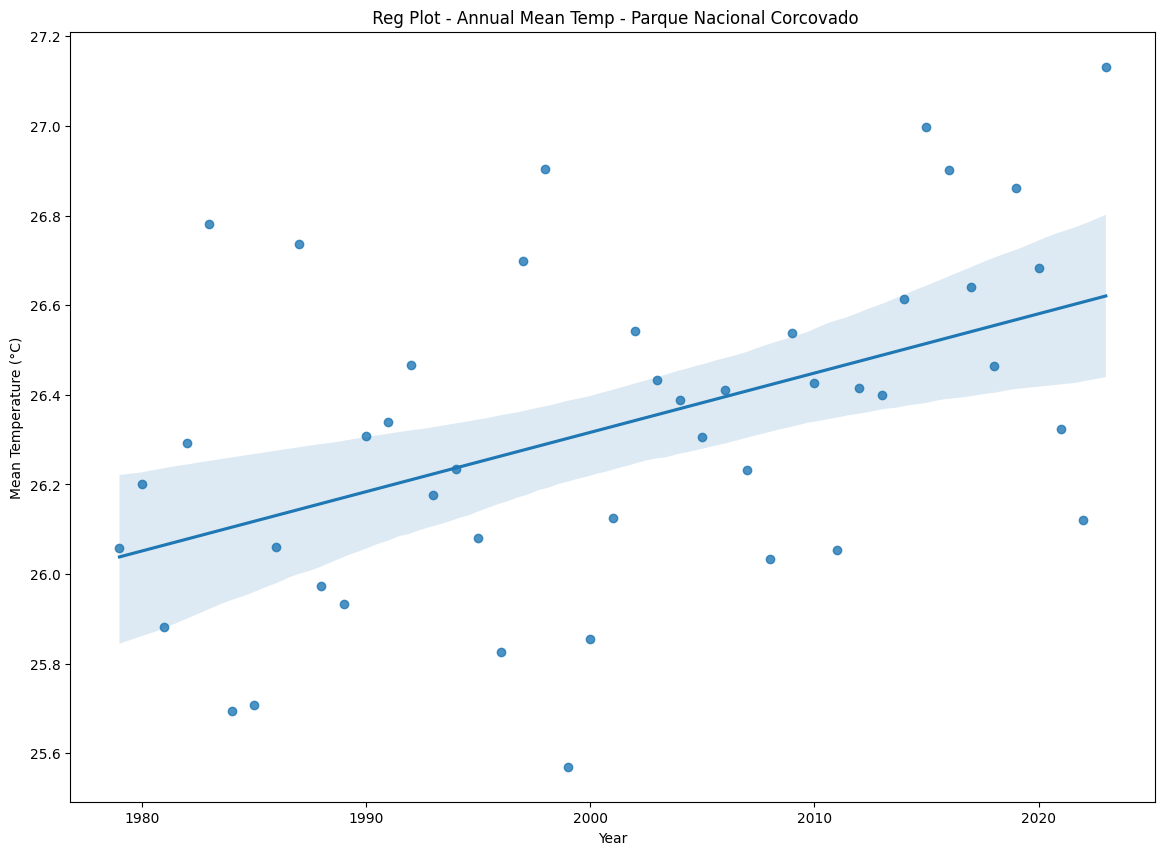

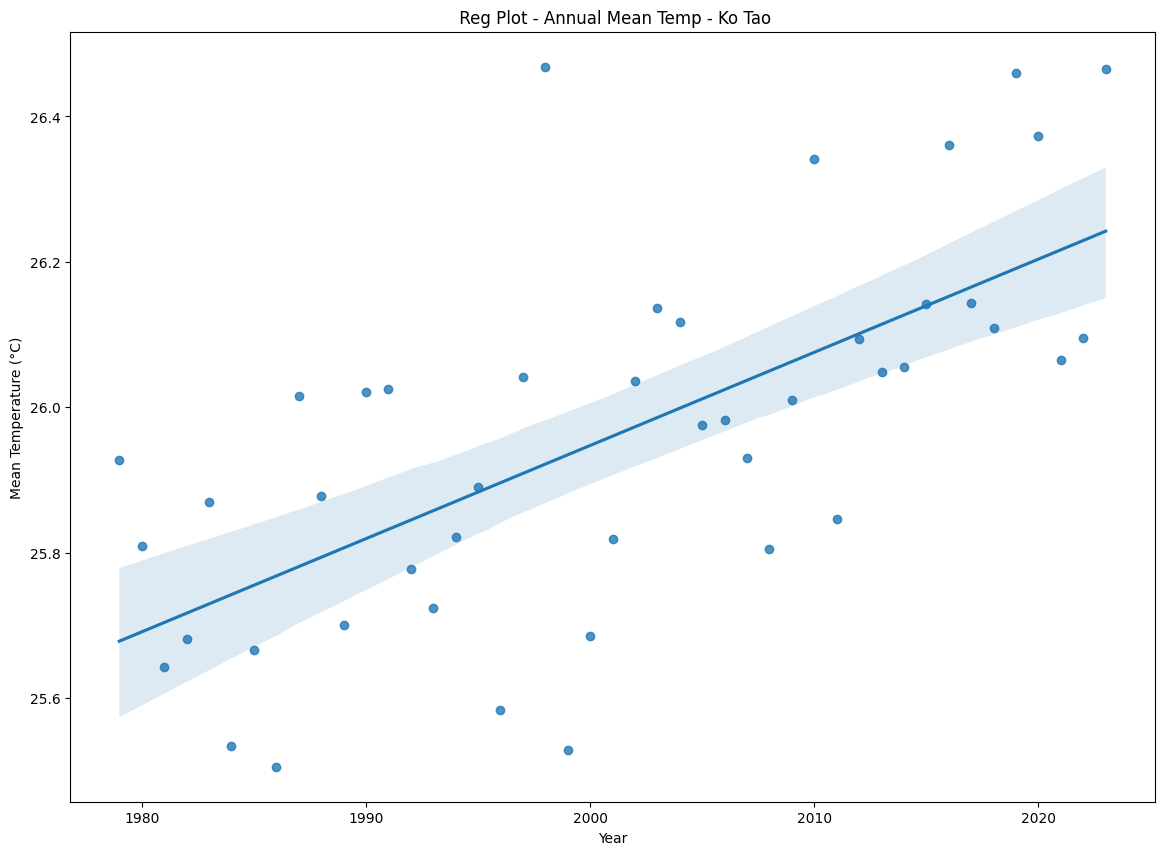

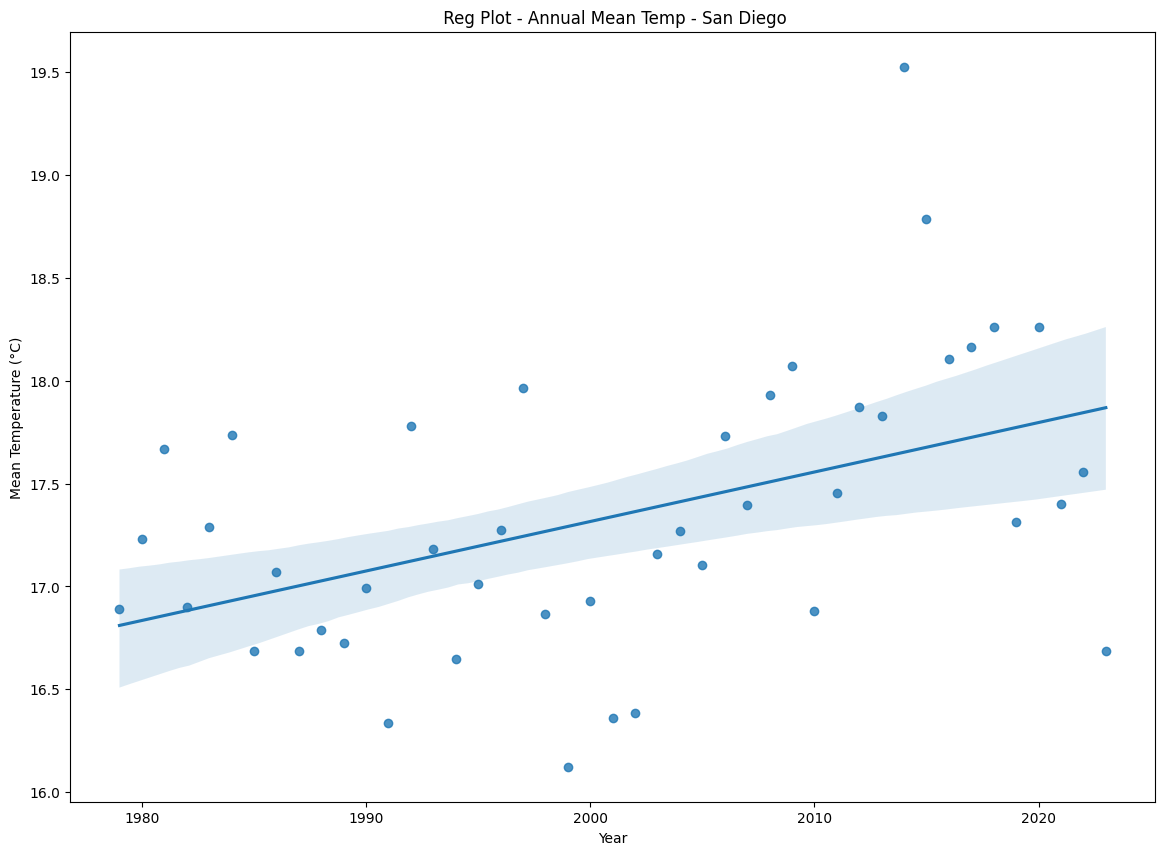

In [17]:
# Regression plots of annual mean temperatures
def regplot_temp(df, city_name):
    
    fig = sns.regplot(x=df['Y'].unique().astype(int), y=df['main.temp'].groupby(df['Y']).mean().astype(float))
    fig.figure.set_size_inches(14, 10)
    plt.xlabel("Year")
    plt.ylabel("Mean Temperature (°C)")
    plt.title(f' Reg Plot - Annual Mean Temp - {city_name}') 
    plt.show(fig)

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    regplot_temp(df, city_name)

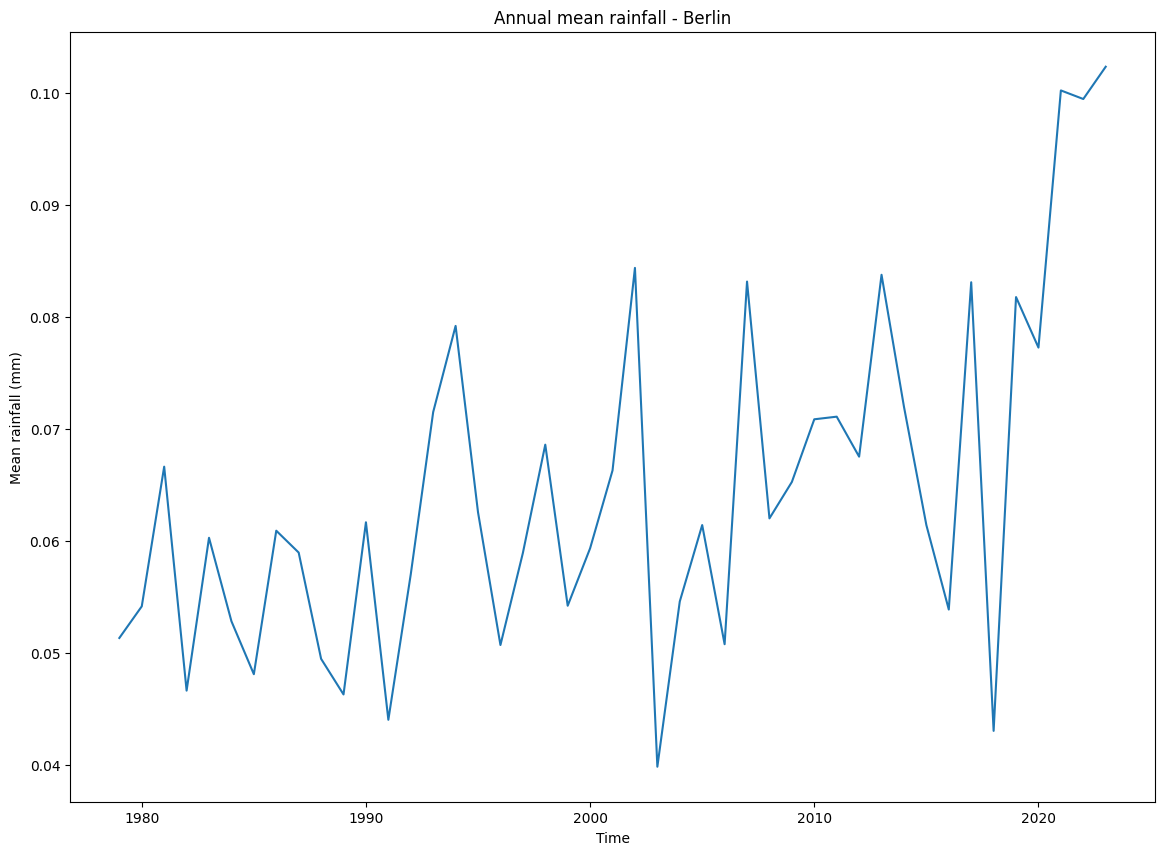

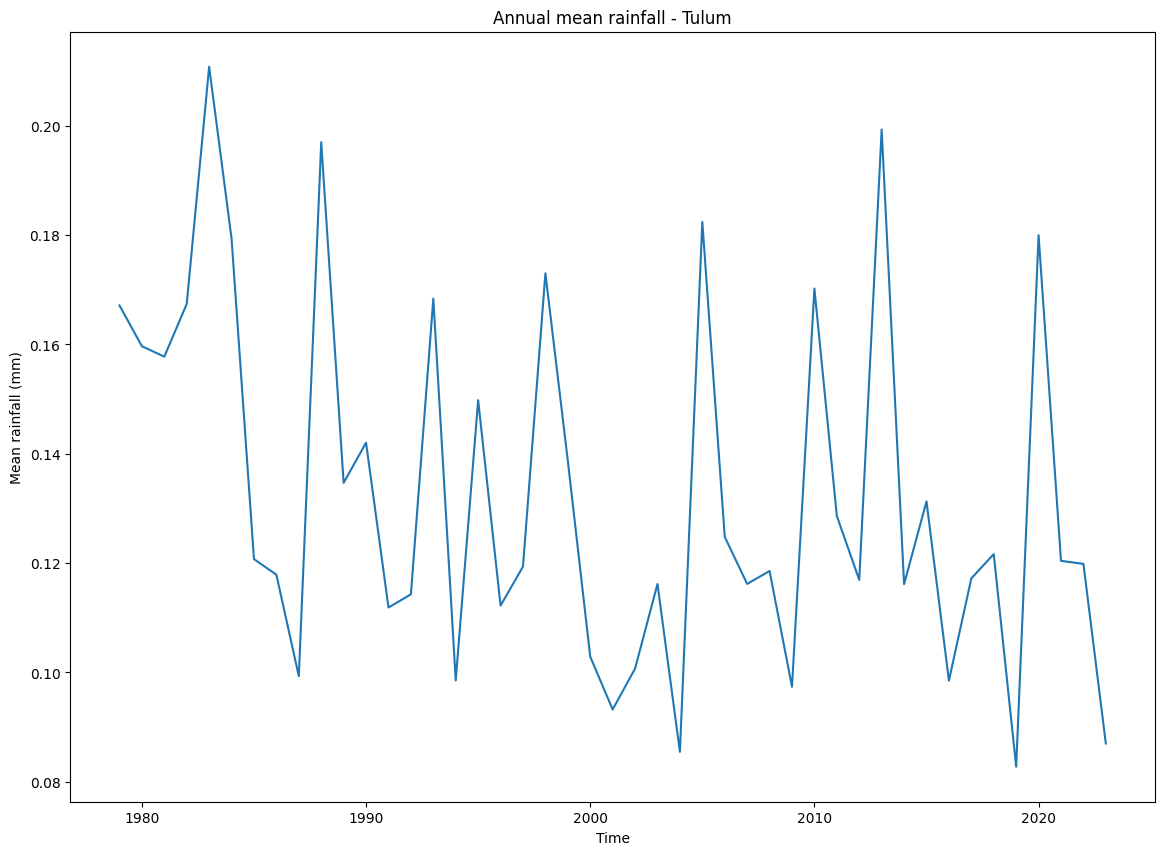

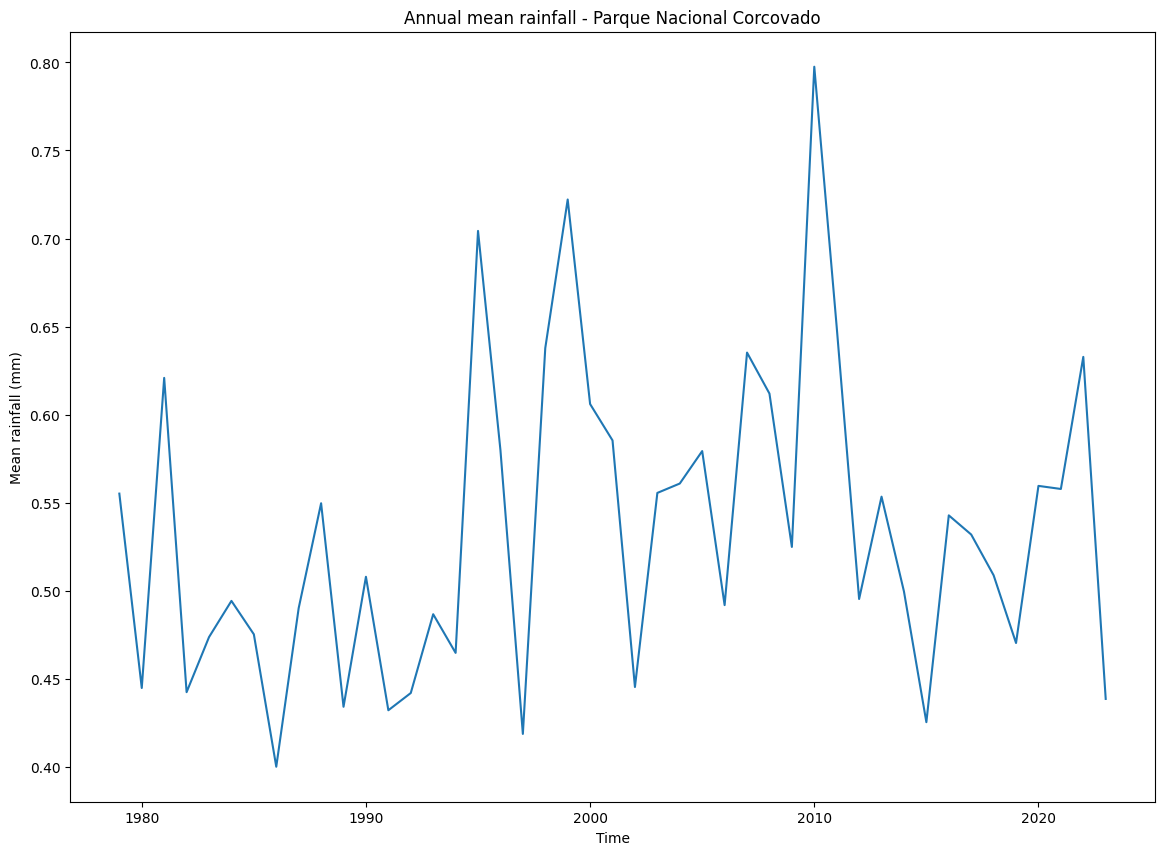

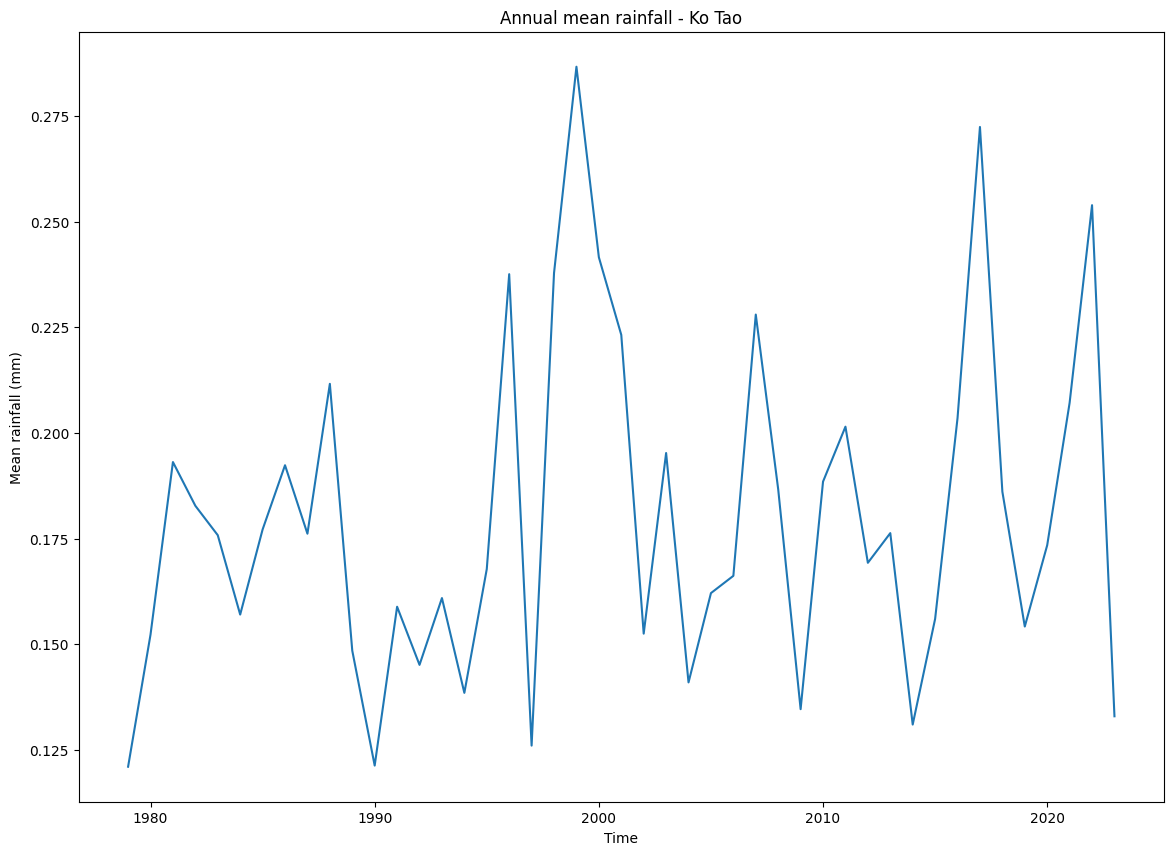

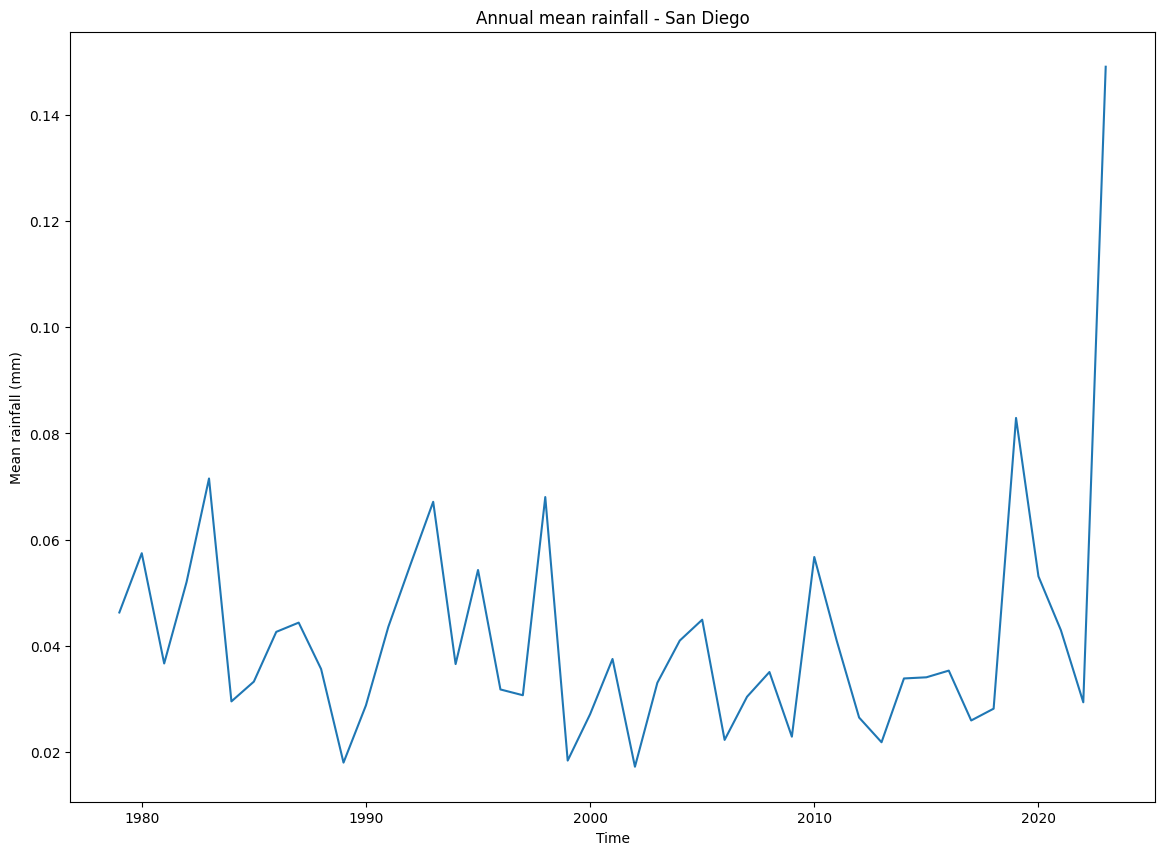

In [18]:
# Plots of annual mean rainfall
def plot_medium_temp(df, city_name):
    df['rain.1h'].groupby(df['Y']).mean().plot(figsize=(14, 10), title=f'Annual mean rainfall - {city_name}')
    plt.xlabel('Time')
    plt.ylabel('Mean rainfall (mm)')
    plt.show()

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    plot_medium_temp(df, city_name)

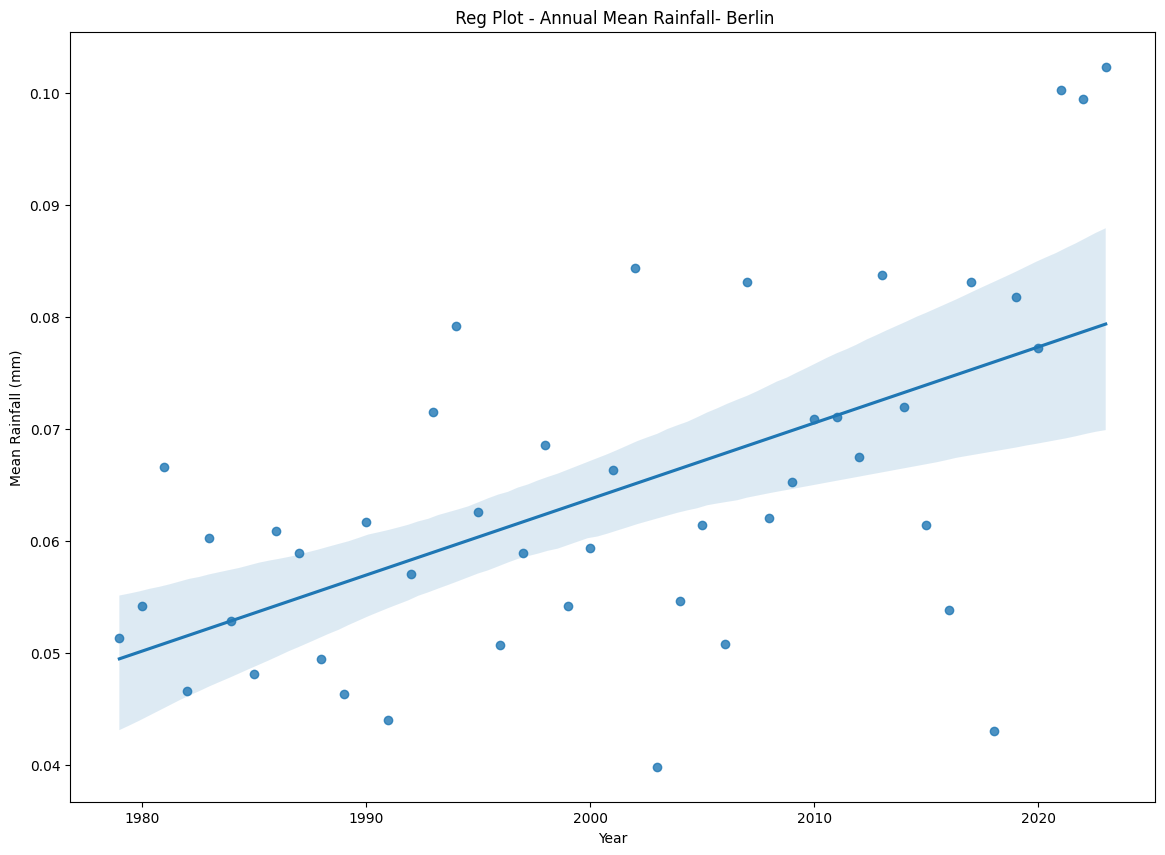

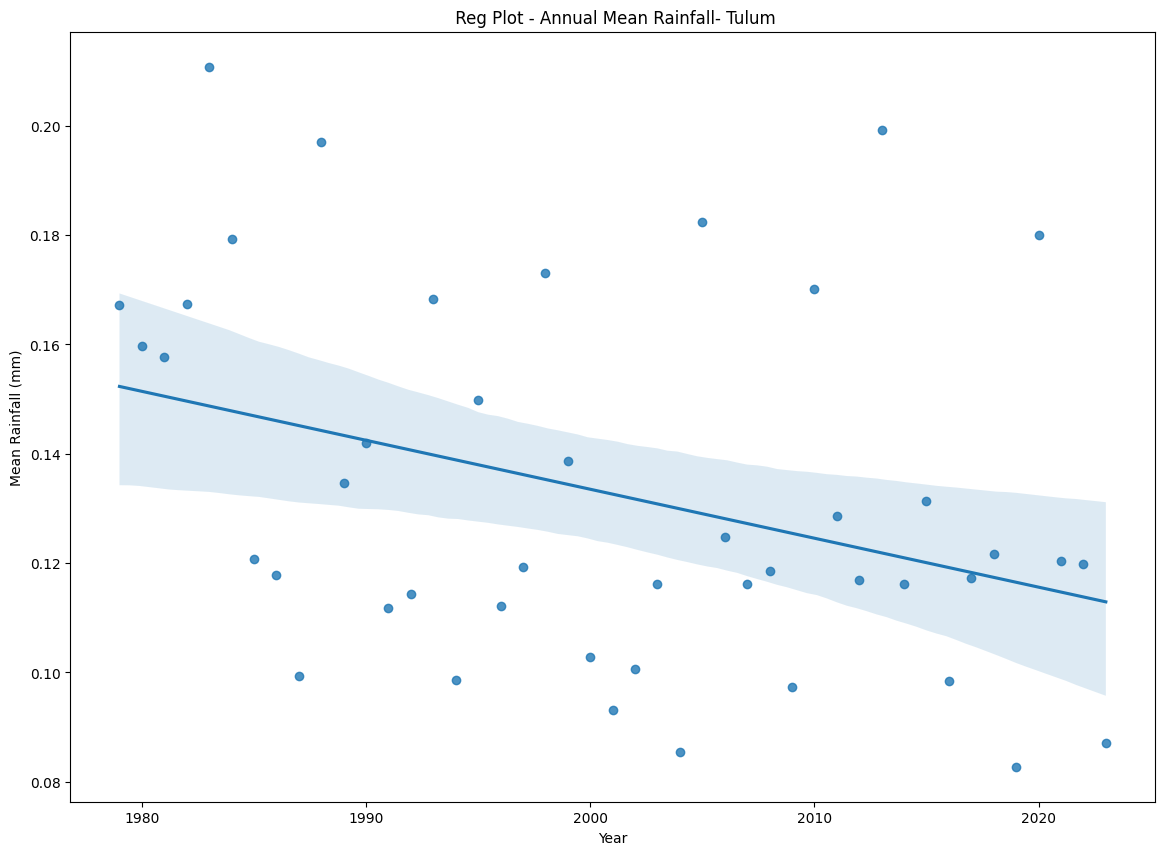

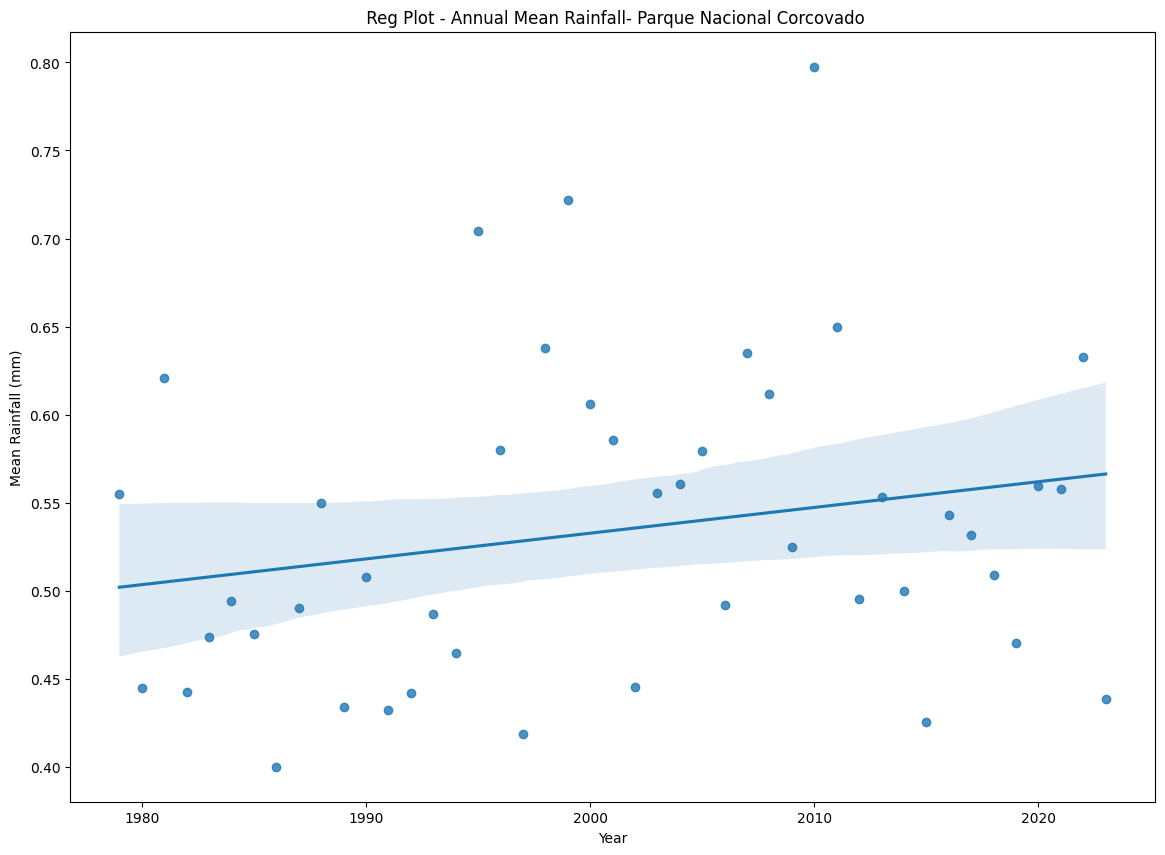

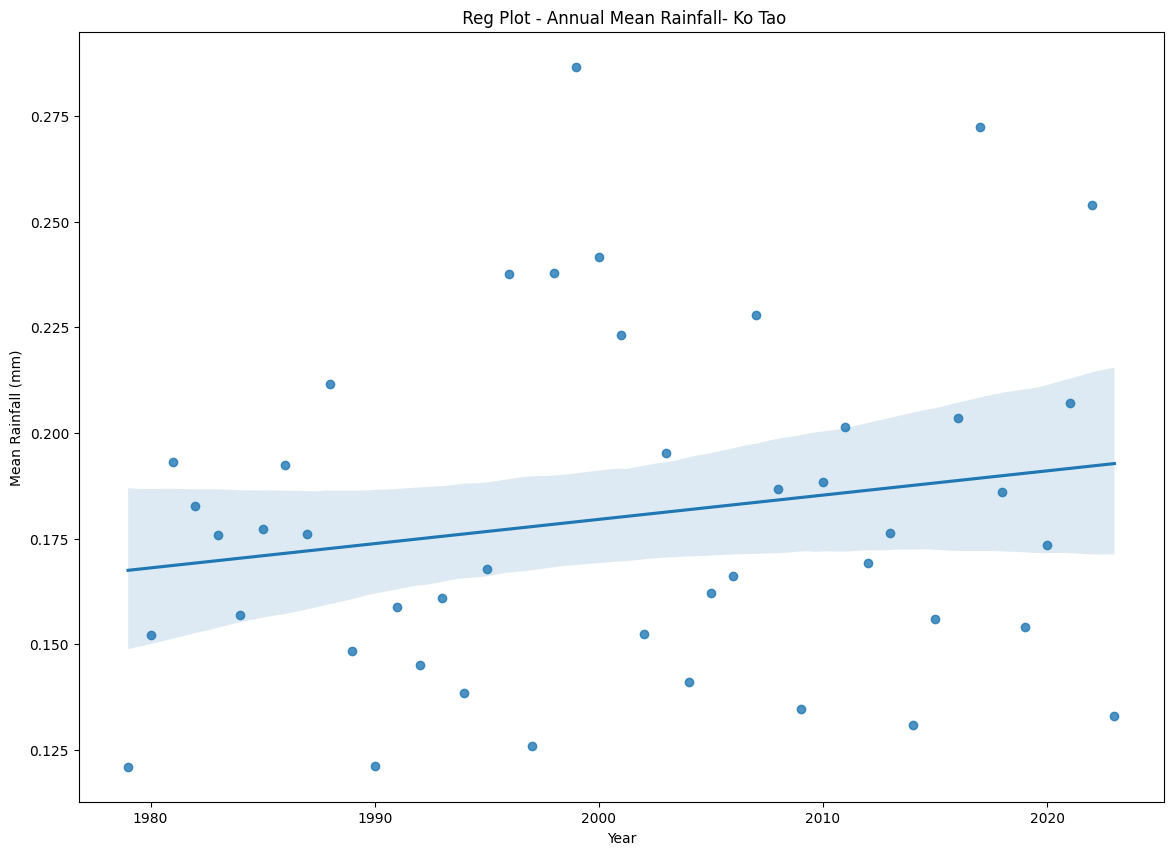

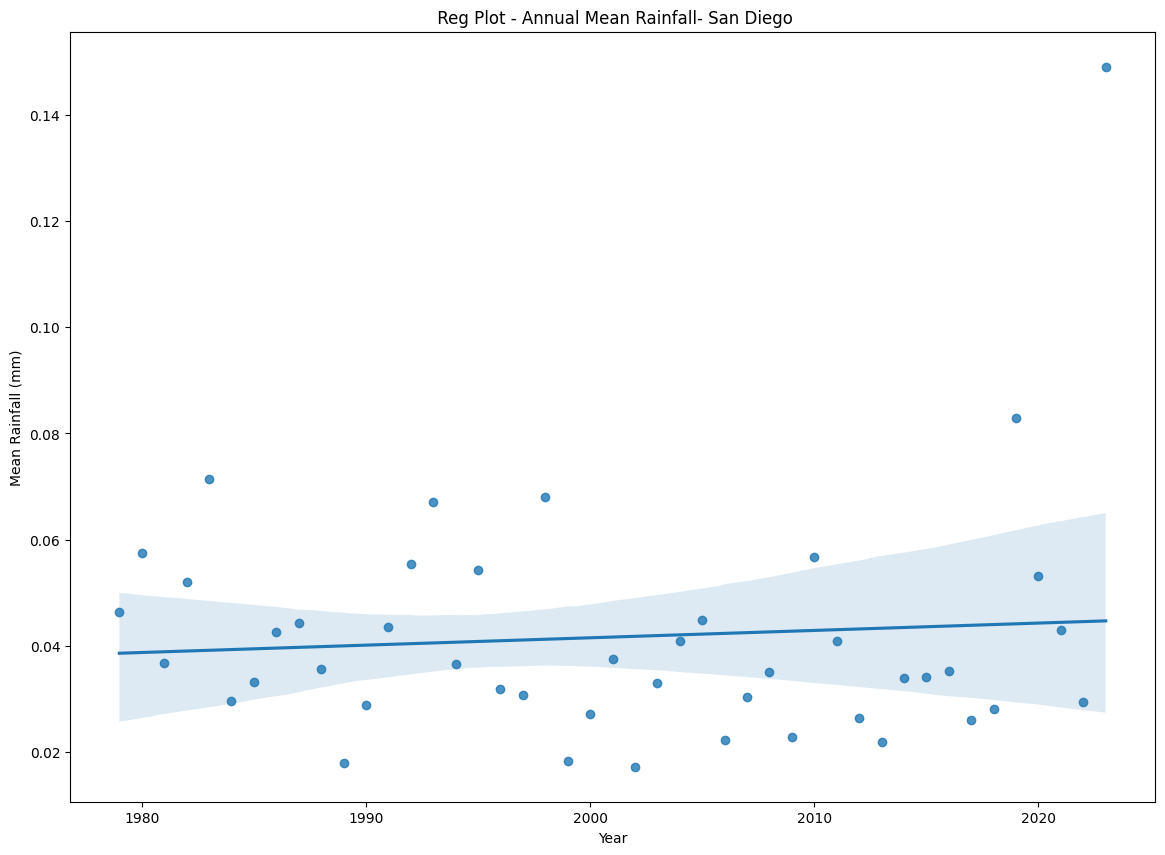

In [21]:
def regplot_rain(df, city_name):
    
    fig = sns.regplot(x=df['Y'].unique().astype(int), y=df['rain.1h'].groupby(df['Y']).mean().astype(float))
    fig.figure.set_size_inches(14, 10)
    plt.xlabel("Year")
    plt.ylabel("Mean Rainfall (mm)")
    plt.title(f' Reg Plot - Annual Mean Rainfall- {city_name}') 
    plt.show(fig)

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    regplot_rain(df, city_name)

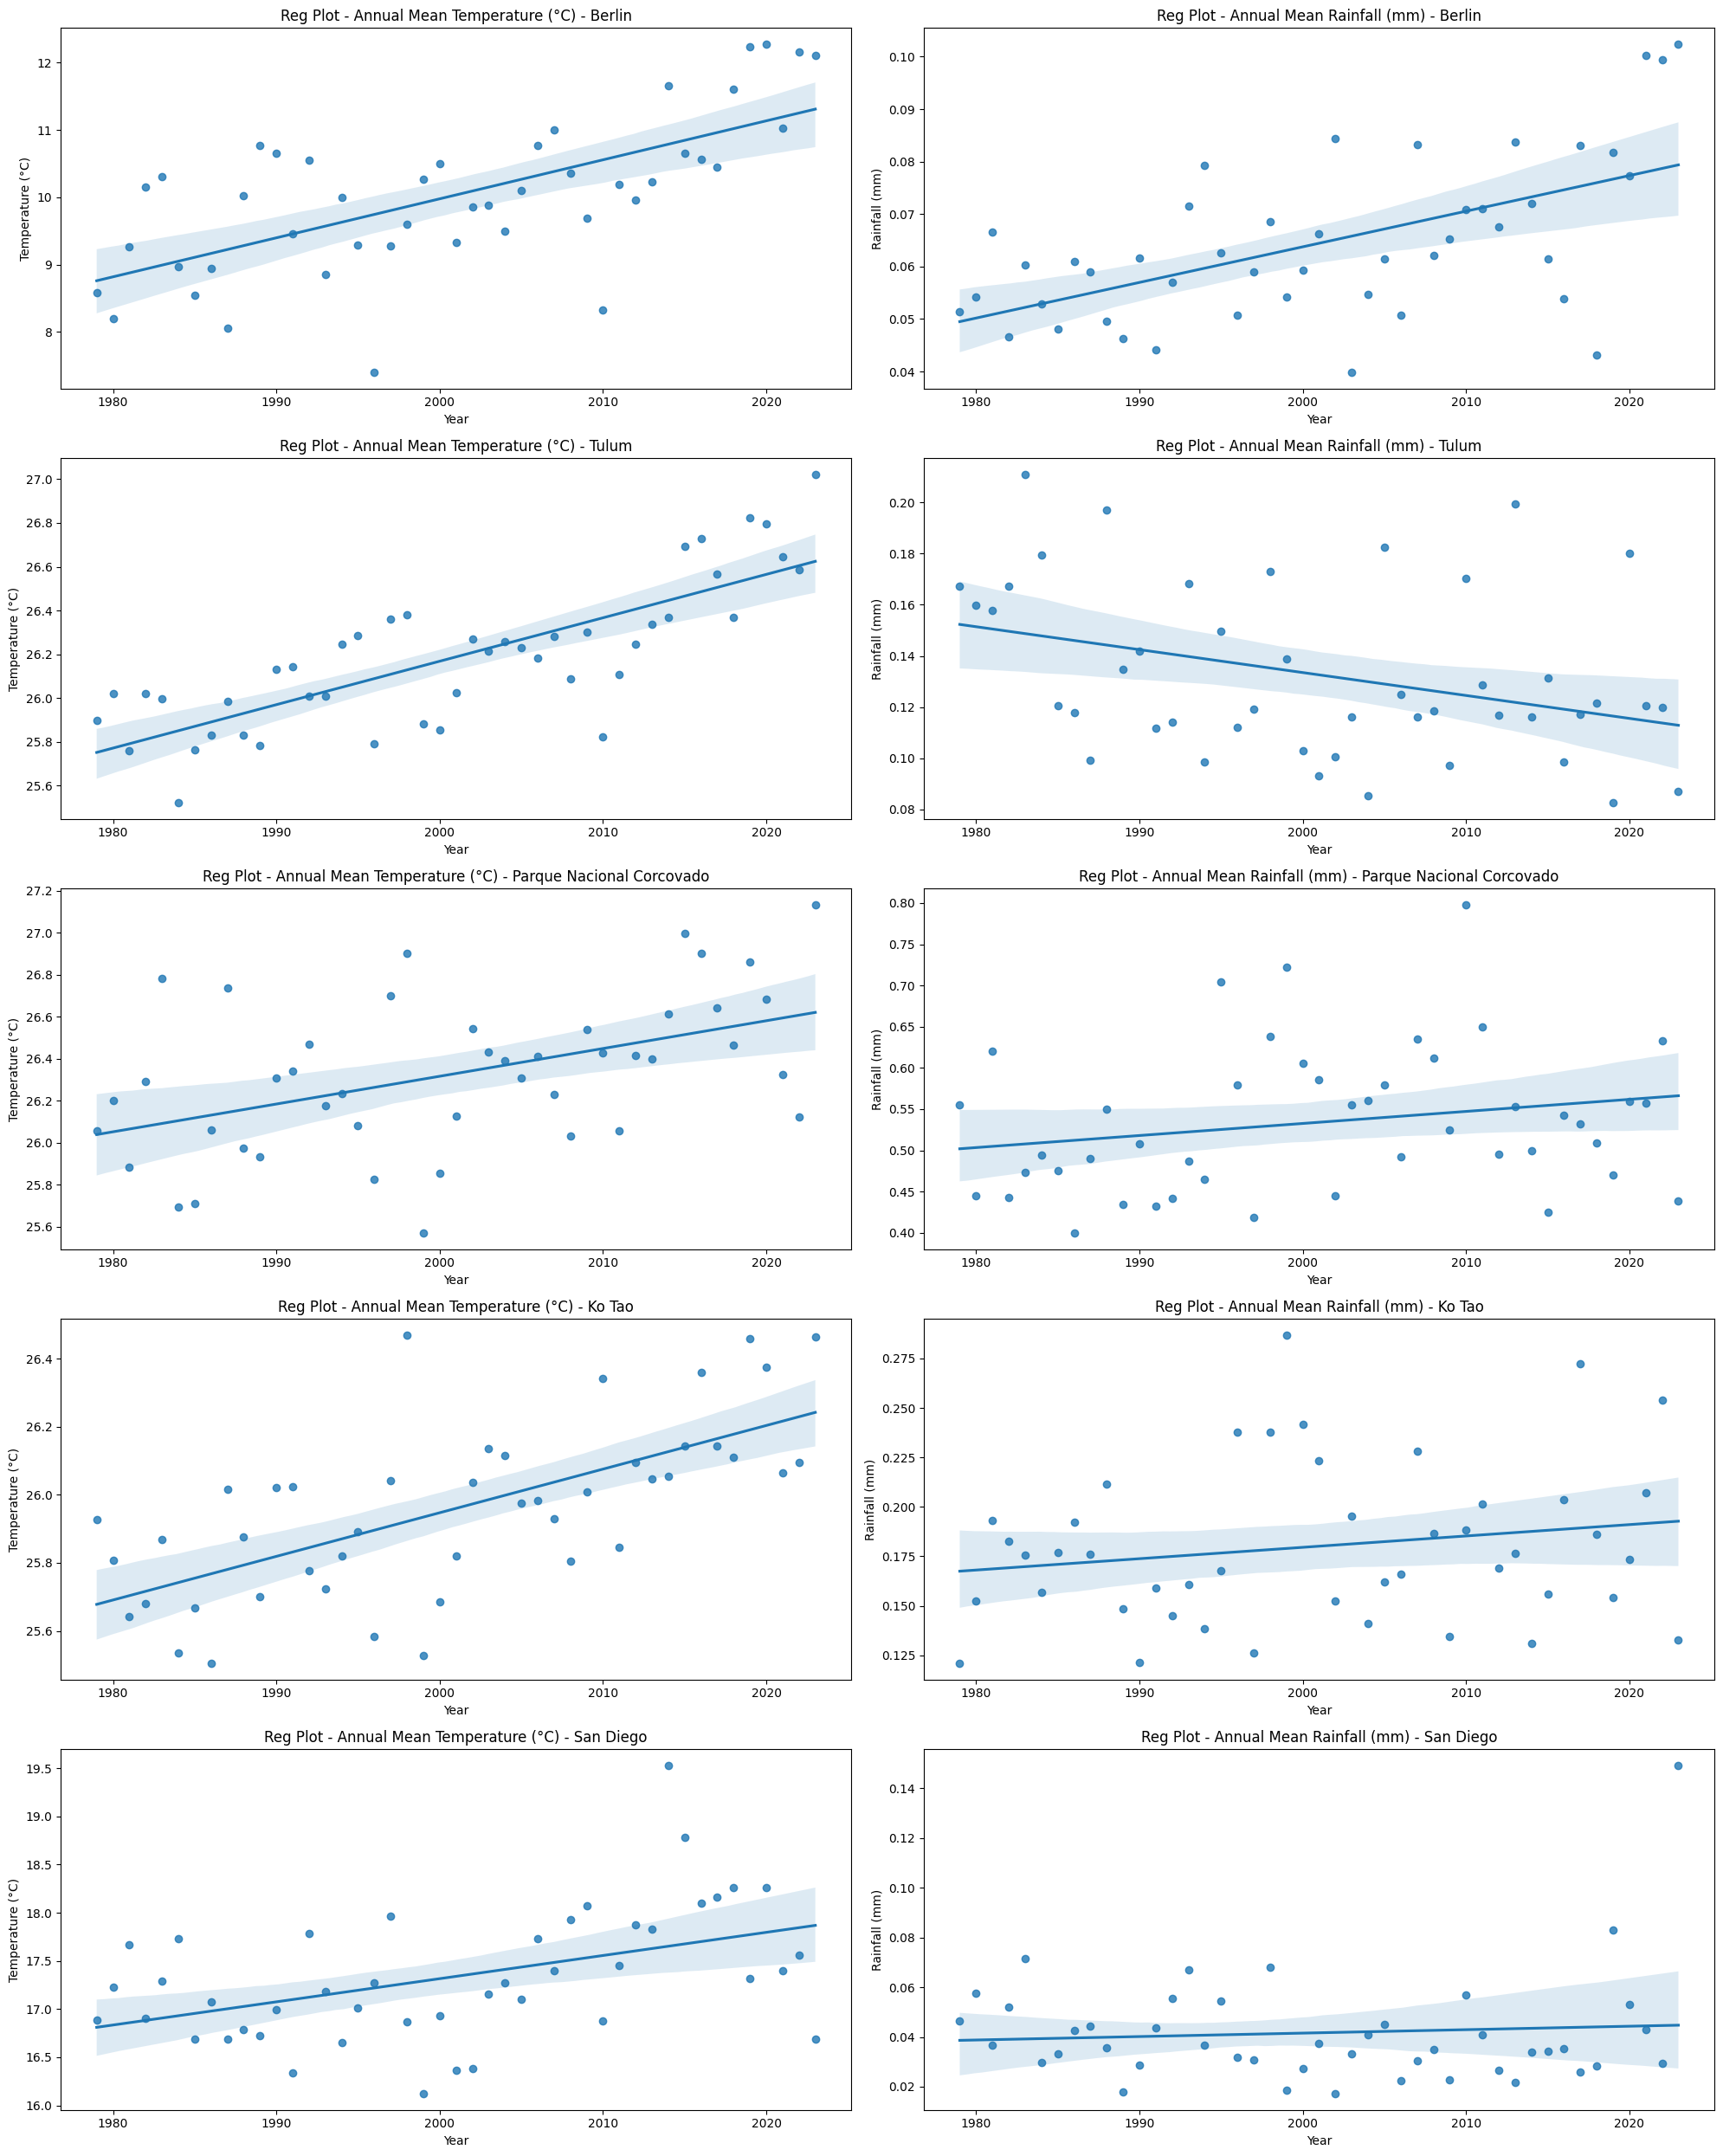

In [22]:
# Plot all combined regression plots for mean annual temperature and rainfall
def regplot_comb(df, city_name, ax, variable, ylabel):
    sns.regplot(x=df['Y'].unique().astype(int), y=df[variable].groupby(df['Y']).mean().astype(float), ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.set_title(f'Reg Plot - Annual Mean {ylabel} - {city_name}')

# Create a 5x2 subplots grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))

# Plot mean annual temperature data on the left side
for i, (city_name, df) in enumerate(zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs)):
    regplot_comb(df, city_name, axes[i, 0], 'main.temp', 'Temperature (°C)')

# Plot mean annual rainfall data on the right side
for i, (city_name, df) in enumerate(zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs)):
    regplot_comb(df, city_name, axes[i, 1], 'rain.1h', 'Rainfall (mm)')

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
# Save filtered dataframes as CSV, compress it, upload it to AWS S3
city_names = ["berlin", "tulum", "corcovado", "kotao", "sandiego"]

def filtered_df_to_CSV_push_to_S3(filtered_weather_history_dfs, city_name):
    client = boto3.client(
        's3',
        aws_access_key_id = aws_access_key,
        aws_secret_access_key = aws_secret_key,
        region_name = 'us-east-1'
    )

    compressed = dict(method='zip', archive_name=f"{city_name}_filtered_weather_history.csv")  
    filtered_weather_history_dfs.to_csv(path_or_buf=f"{my_path}/{city_name}_filtered_weather_history.zip", index=False, compression=compressed)
    client.upload_file(my_path+"/"+f"{city_name}_filtered_weather_history.zip", 'weather-data-history', f"{city_name}_filtered_weather_history.zip")

    return "Done."
    
for city_df, city_name in zip(filtered_city_dfs, city_names):
    filtered_df_to_CSV_push_to_S3(city_df, city_name)

In [26]:
# Connecting to AWS PostgreSQL DB
try:
    conn2 = ps.connect(dbname = rds_database, 
                       user = rds_user, 
                       password = rds_password, 
                       host = rds_host, 
                       port = rds_port)
    conn2.autocommit = True
    cur = conn2.cursor()
    print('Connection established.')
except:
    print("Error while connecting to PostgreSQL.")

Connection established.


In [29]:
# Create RDS table for current weather
for df in filtered_city_dfs:
    # Extract the city name from the dataframe
    city_name = df['city_name'].iloc[0].lower().replace(" ", "_")

    # Create RDS table for current weather for each city
    try:
        cur.execute(f"CREATE TABLE IF NOT EXISTS weather_history_filtered_{city_name} (city_name varchar(255), date_column timestamp, \"main.temp\" float8, \"rain.1h\" float8, Y int)")
        print(f"Table for {city_name} created successfully")
    except Exception as e:
        print(f"Error while creating table for {city_name}: {e}")

    # Convert dataframe rows to a list of tuples for executemany
    rows = [tuple(row) for row in df[['city_name', 'date_column', 'main.temp', 'rain.1h', 'Y']].itertuples(index=False, name=None)]

    # Insert current weather data into table for each city using executemany
    try:
        cur.executemany(f"INSERT INTO weather_history_filtered_{city_name} (city_name, date_column, \"main.temp\", \"rain.1h\", Y) VALUES (%s, %s, %s, %s, %s)", rows)
        print(f"Data for {city_name} inserted successfully")
    except Exception as e:
        print(f"Error while inserting data for {city_name}: {e}")
        
conn2.commit()    
cur.close()
conn2.close()

Table for berlin created successfully


KeyboardInterrupt: 